# Forecasting FTSE100 realised volatilities using the LSTM model 

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from datetime import timedelta
df = pd.read_excel('/Users/marapopescu/Desktop/Thesis/graphs/Rvol-only.xlsx')
df = pd.DataFrame(df)
print(df)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/marapopescu/Desktop/Thesis/graphs/Rvol-only.xlsx'

In [2]:
df['date'] = pd.to_datetime(df['date'])
print(df)

           date      RVOL
0    2004-01-01  0.469163
1    2004-01-08  0.449586
2    2004-01-15  0.440296
3    2004-01-22  0.418011
4    2004-01-29  0.543417
...         ...       ...
1039 2023-11-30  0.477435
1040 2023-12-07  0.235358
1041 2023-12-14  0.783664
1042 2023-12-21  0.199476
1043 2023-12-28  0.052022

[1044 rows x 2 columns]


In [3]:
df['date']

0      2004-01-01
1      2004-01-08
2      2004-01-15
3      2004-01-22
4      2004-01-29
          ...    
1039   2023-11-30
1040   2023-12-07
1041   2023-12-14
1042   2023-12-21
1043   2023-12-28
Name: date, Length: 1044, dtype: datetime64[ns]

In [4]:
df

,date,RVOL
0,2004-01-01,0.469163
1,2004-01-08,0.449586
2,2004-01-15,0.440296
3,2004-01-22,0.418011
4,2004-01-29,0.543417
...,...,...
1039,2023-11-30,0.477435
1040,2023-12-07,0.235358
1041,2023-12-14,0.783664
1042,2023-12-21,0.199476


In [5]:
df.index=df.pop('date')
df

,RVOL
date,
2004-01-01,0.469163
2004-01-08,0.449586
2004-01-15,0.440296
2004-01-22,0.418011
2004-01-29,0.543417
...,...
2023-11-30,0.477435
2023-12-07,0.235358
2023-12-14,0.783664


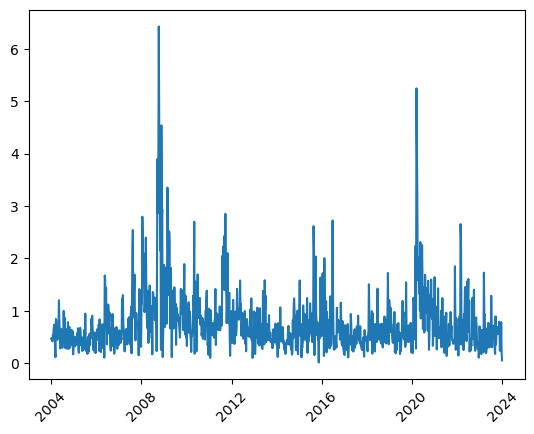

In [6]:
import matplotlib.pyplot as plt
plt.xticks(rotation=45)

plt.plot(df.index, df['RVOL'])

In [7]:
import datetime

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

In [8]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=1):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
  
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['RVOL'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
        if last_time:
            break
    
        target_date = next_date
        
        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
    
    ret_df['Target'] = Y
    
    return ret_df

In [9]:
windowed_df = df_to_windowed_df(df, 
                                '2004-01-22', 
                                '2023-12-28', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2004-01-22,0.469163,0.449586,0.440296,0.418011
1,2004-01-29,0.449586,0.440296,0.418011,0.543417
2,2004-02-05,0.440296,0.418011,0.543417,0.505170
3,2004-02-12,0.418011,0.543417,0.505170,0.661596
4,2004-02-19,0.543417,0.505170,0.661596,0.733161
...,...,...,...,...,...
1036,2023-11-30,0.789924,0.730562,0.239154,0.477435
1037,2023-12-07,0.730562,0.239154,0.477435,0.235358
1038,2023-12-14,0.239154,0.477435,0.235358,0.783664
1039,2023-12-21,0.477435,0.235358,0.783664,0.199476


In [10]:
import numpy as np

def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))  # we use 1 as the last parameter because we have a univariate model
    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

# Assuming you have already defined windowed_df
dates, X, y = windowed_df_to_date_X_y(windowed_df)
print(dates.shape, X.shape, y.shape)


(1041,) (1041, 3, 1) (1041,)


### Data split

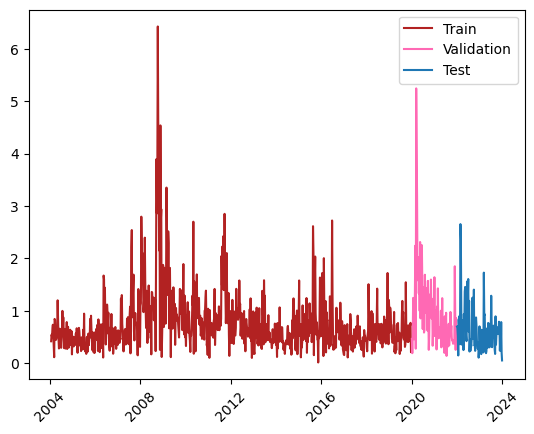

In [11]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]
plt.xticks(rotation=45)

plt.plot(dates_train, y_train, color='firebrick')
plt.plot(dates_val, y_val, color='hotpink')
plt.plot(dates_test, y_test)
 
plt.legend(['Train', 'Validation', 'Test'])

### Constructing the model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)), #we use 3 lags and 1 feature for forecasting
                    layers.LSTM(64), #LSTM layer with 64 neurons; the bigger the more complex and prone to overfitting
                    layers.Dense(32, activation='relu'), #2 dense layer 
                    layers.Dense(32, activation='relu'), 
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_squared_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7476 - mean_squared_error: 0.7476 - val_loss: 0.5906 - val_mean_squared_error: 0.5906
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2532 - mean_squared_error: 0.2532 - val_loss: 0.4295 - val_mean_squared_error: 0.4295
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2571 - mean_squared_error: 0.2571 - val_loss: 0.4277 - val_mean_squared_error: 0.4277
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2048 - mean_squared_error: 0.2048 - val_loss: 0.4336 - val_mean_squared_error: 0.4336
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.4277 - val_mean_squared_error: 0.4277
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3056 - mean_squared_error: 0.3056 - val_loss: 0.4444 - val_mean_squared_error: 0.4444
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 0.2127 - mean_squared_error: 0.2127 - val_loss: 0.4301

## Training set

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step


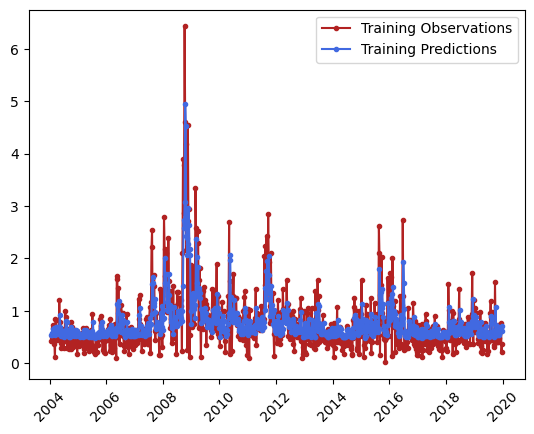

In [13]:
train_predictions = model.predict(X_train).flatten()
plt.xticks(rotation=45)

# observations-red
plt.plot(dates_train, y_train, color='firebrick', marker='.', linestyle='-', label='Training Predictions')  # Skyblue with circle markers
# predictions-blue
plt.plot(dates_train, train_predictions, color='royalblue', marker='.', linestyle='-', label='Training Observations')  # Green with dashed line

plt.legend(['Training Observations', 'Training Predictions'])

## Validation set

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


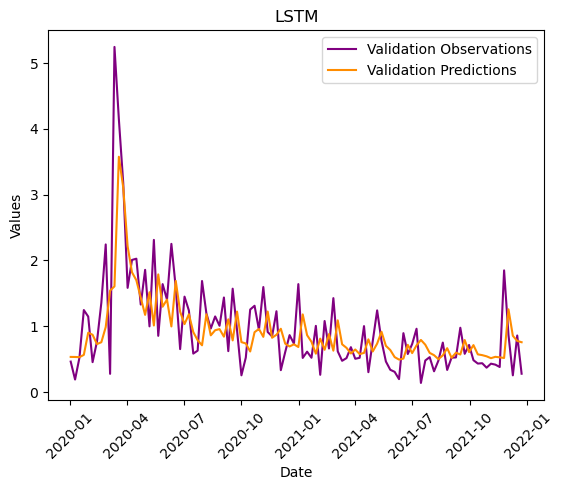

In [14]:
val_predictions = model.predict(X_val).flatten()
plt.xticks(rotation=45)
plt.plot(dates_val, y_val, color='purple', linestyle='-', label='Validation Observations')  # Red with circle markers
plt.plot(dates_val, val_predictions, color='darkorange', linestyle='-', label='Validation Predictions') 
plt.title('LSTM')
plt.xlabel('Date')
plt.ylabel('Values')# Magenta with dashed line
plt.legend(['Validation Observations', 'Validation Predictions'])

In [15]:
validation_results = pd.DataFrame({
    'Date': dates_val,
    'Actual': y_val,
    'Prediction': val_predictions
})

# Save the DataFrame to a new CSV file
validation_results.to_csv('validation_predictions.csv', index=False)

### MSE VALIDATION DATA

In [16]:
print("Evaluate on validation data")
results = model.evaluate(X_val, y_val, batch_size=64)
print("test loss, test acc:", results)

Evaluate on validation data
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3990 - mean_squared_error: 0.3990 
test loss, test acc: [0.35122597217559814, 0.35122597217559814]


## TEST DATA 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


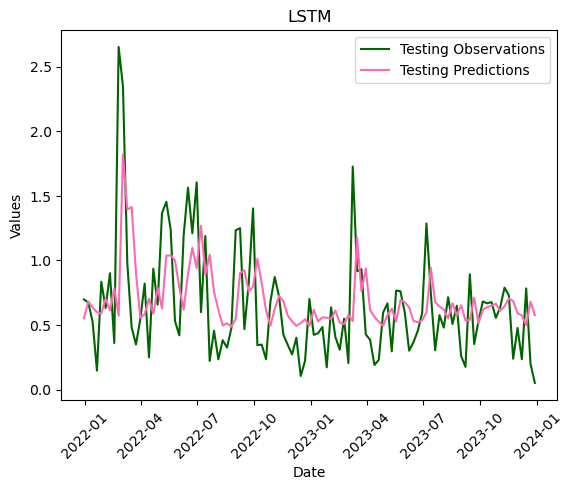

In [17]:
test_predictions = model.predict(X_test).flatten()
plt.xticks(rotation=45)
plt.plot(dates_test, y_test, color='darkgreen', linestyle='-', label='Testing Observations')  # Cyan with circle markers
plt.plot(dates_test, test_predictions, color='hotpink', linestyle='-', label='Testing Predictions')  # Yellow with dashed line
plt.title('LSTM')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(['Testing Observations', 'Testing Predictions'])

In [18]:
test_results = pd.DataFrame({
    'Date': dates_test,
    'Actual': y_test,
    'Prediction': test_predictions
})

# Save the DataFrame to a new CSV file
test_results.to_csv('test_predictions.csv', index=False)

### MSE TEST DATA

In [19]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1968 - mean_squared_error: 0.1968
test loss, test acc: [0.1756211370229721, 0.1756211370229721]


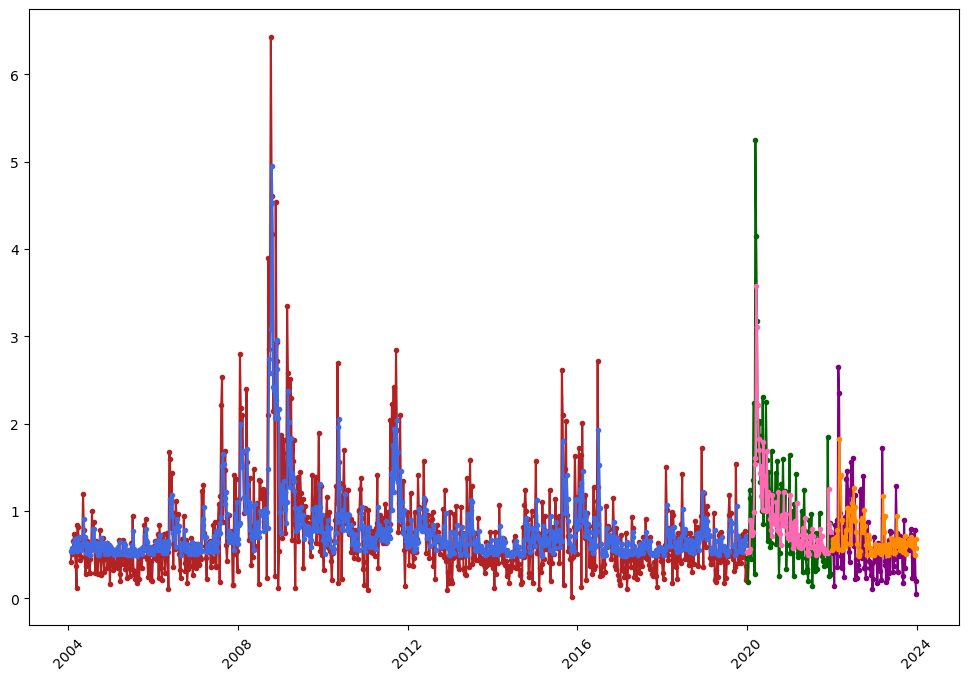

In [20]:
plt.figure(figsize=(12, 8))

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.plot(dates_train, y_train, color='firebrick', marker='.', linestyle='-', label='Training Observations')  # Skyblue with circle markers
plt.plot(dates_train, train_predictions, color='royalblue', marker='.', linestyle='-', label='Training Predictions')  # Green with dashed line

plt.plot(dates_val, y_val, color='darkgreen', marker='.', linestyle='-', label='Validation Observations')  # Red with circle markers
plt.plot(dates_val, val_predictions, color='hotpink', marker='.', linestyle='-', label='Validation Predictions')  # Magenta with dashed line

plt.plot(dates_test, y_test, color='purple', marker='.', linestyle='-', label='Testing Observations')  # Cyan with circle markers
plt.plot(dates_test, test_predictions, color='darkorange', marker='.', linestyle='-', label='Testing Predictions')  # Yellow with dashed line


In [21]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

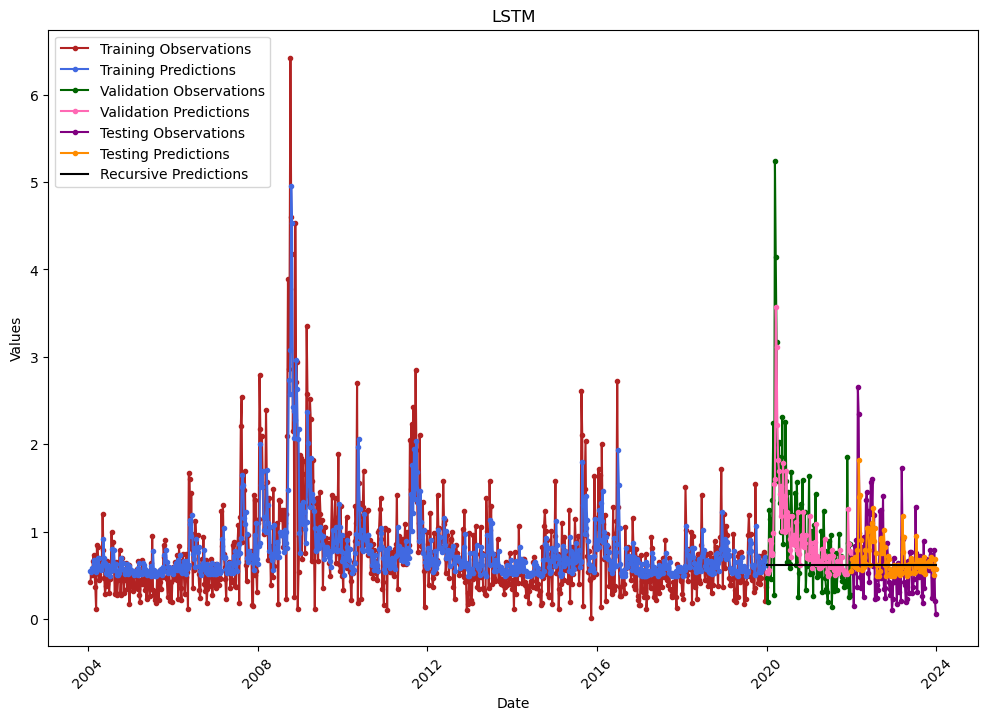

In [24]:
plt.figure(figsize=(12, 8))

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

plt.plot(dates_train, y_train, color='firebrick', marker='.', linestyle='-', label='Training Observations')  # Skyblue with circle markers
plt.plot(dates_train, train_predictions, color='royalblue', marker='.', linestyle='-', label='Training Predictions')  # Green with dashed line

plt.plot(dates_val, y_val, color='darkgreen', marker='.', linestyle='-', label='Validation Observations')  # Red with circle markers
plt.plot(dates_val, val_predictions, color='hotpink', marker='.', linestyle='-', label='Validation Predictions')  # Magenta with dashed line

plt.plot(dates_test, y_test, color='purple', marker='.', linestyle='-', label='Testing Observations')  # Cyan with circle markers
plt.plot(dates_test, test_predictions, color='darkorange', marker='.', linestyle='-', label='Testing Predictions')  # Yellow with dashed line

plt.plot(recursive_dates, recursive_predictions, color='black', linestyle='-', label='Recursive Predictions')  # Black with circle markers

# Add a legend
plt.legend()
plt.title('LSTM')
plt.xlabel('Date')
plt.ylabel('Values')# Magenta with dashed line
# Show the plot
plt.show()


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2014 - mean_squared_error: 0.2014 - val_loss: 0.3471 - val_mean_squared_error: 0.3471
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1890 - mean_squared_error: 0.1890 - val_loss: 0.3493 - val_mean_squared_error: 0.3493
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1947 - mean_squared_error: 0.1947 - val_loss: 0.3495 - val_mean_squared_error: 0.3495
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1706 - mean_squared_error: 0.1706 - val_loss: 0.3547 - val_mean_squared_error: 0.3547
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2015 - mean_squared_error: 0.2015 - val_loss: 0.3574 - val_mean_squared_error: 0.3574
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1933 - mean_squared_error: 0.1933 - val_loss: 0.3456 - val_mean_squared_error: 0.3456
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2031 - mean_squared_error: 0.2031 - val_loss: 0.3670 - va

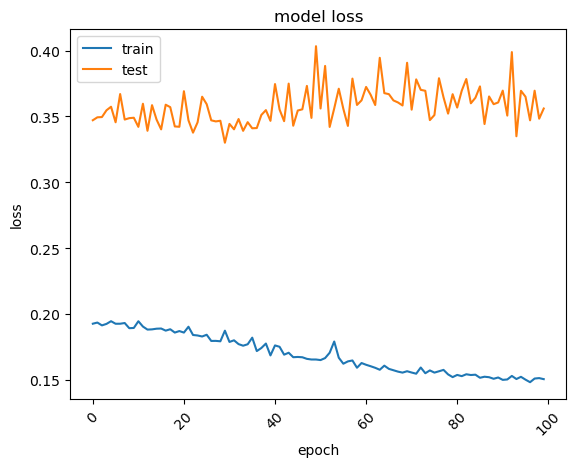

In [23]:
 
history =model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
plt.xticks(rotation=45) 
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()